# Init

In [414]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load
import os
import copy
import datetime
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Pre-process raw data

The data consists of the following information:

* **Patient**: id, age, sex, health status, ...

* **Treatment**: duration, date, category, details (DVGS codes, codes for used endoscopes, indicators for emergency, stay/ambulant treatemnts), ...

* **Surgeons**: information on surgeons, assistants, and nurses that conducted the treatment

Each row in the data belongs to one surgery / treatment / examination.

In [415]:
# Load raw data
data = pd.read_csv('/home/fesc/dddex/PatientScheduling/Data/dataHCScheduling2.csv', sep=';')

In [416]:
# Format dates and add columns for year, month, ...
for r in range(len(data)):
    
    date = [int(i) for i in reversed(data['Datum'].iloc[r].split('.'))]

    data.loc[r, 'year'] = 2000+date[0]
    data.loc[r, 'month'] = date[1]
    data.loc[r, 'week'] = datetime.date(year=2000+date[0], month=date[1], day=date[2]).isocalendar()[1]
    data.loc[r, 'day'] = date[2]
    data.loc[r, 'weekday'] = datetime.date(year=2000+date[0], month=date[1], day=date[2]).weekday()
    data.loc[r, 'date'] = datetime.date(year=2000+date[0], month=date[1], day=date[2])

In [417]:
# Select dates
data = data.loc[data['date'] <= datetime.date(2019, 12, 31)]

In [418]:
# Treatment areas
areas = [
    
    'Bereich_Bronchoskopie', # bronchoscopy
    'Bereich_ERCP',          # endoscopic retrograde cholangiopancreatography
    'Bereich_Endosonographie', # endosonography
    'Bereich_Gastroskopie', # gastroscopy
    'Bereich_Koloskopie' # colonoscopy
    
]

In [419]:
# Add treatment areas to data
area = [areas[i] for i in np.where(np.array(data[areas]) == 1)[1]]
data['area'] = area

In [420]:
# Team setup
# TODO: Teamgröße, Anzahl  Ärzte, Assistenzen und Leistungen

In [421]:
# 1-hot encode type of hospitalization ('Aufenthalt')
enc = OneHotEncoder()
enc = enc.fit(np.array(data['Aufenthalt']).reshape(-1,1))
hospitalization = enc.transform(np.array(data['Aufenthalt']).reshape(-1,1)).toarray()
cols = enc.get_feature_names_out(['Aufenthalt'])
data[cols] = hospitalization
data = data.rename(columns={'Aufenthalt': 'hospitalization'})

In [422]:
# Remove NaN in sex
data = data.loc[~np.isnan(data.Geschlecht)]

# Simple EDA

In [423]:
# See "size" of areas
data.groupby('area').agg({'patient_id': len})

,patient_id
area,
Bereich_Bronchoskopie,551
Bereich_ERCP,514
Bereich_Endosonographie,568
Bereich_Gastroskopie,4039
Bereich_Koloskopie,1706


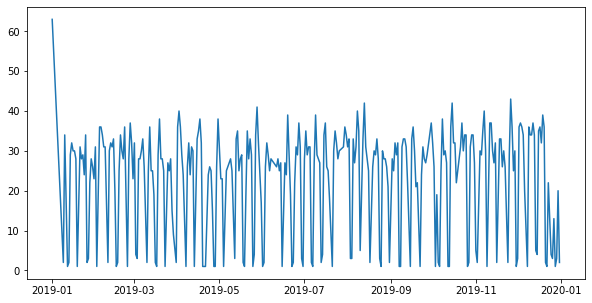

In [424]:
# Number of cases per day
plotData = data.groupby(['date']).agg(M=('patient_id', len)).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
p = ax.plot(plotData['date'], plotData['M'])

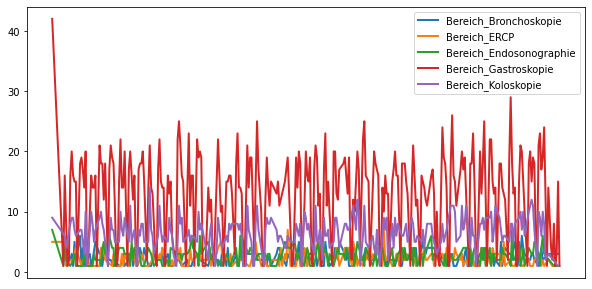

In [425]:
# Number of cases per day by area
plotData = data.groupby(['date', 'area']).agg(M=('patient_id', len)).reset_index().groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d.M, marker='', linestyle='-', ms=2, linewidth=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

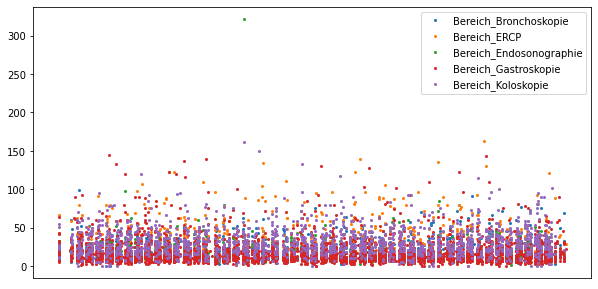

In [426]:
# Duration by area
plotData = data.groupby('area')

# Plot
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

for area, d in plotData:
    ax.plot(d['date'], d['Dauer'], marker='o', linestyle='', ms=2, label=area)
ax.legend()
ax.get_xaxis().set_visible(False)
plt.show()

In [427]:
# Average number of cases and case duration per day by area
data.groupby(['date', 'area']).agg(
    n_cases=('patient_id', len),
    duration=('Dauer', np.mean),
).groupby('area').agg(
    n_cases=('n_cases', np.mean),
    duration=('duration', np.mean)
).reset_index()

,area,n_cases,duration
0,Bereich_Bronchoskopie,2.448889,25.830593
1,Bereich_ERCP,2.284444,41.958910
2,Bereich_Endosonographie,2.730769,20.371909
3,Bereich_Gastroskopie,12.904153,19.134803
4,Bereich_Koloskopie,6.638132,31.293970


# Select and prepare data for training and testing

## Temporal train-test split

In [428]:
# Select a split for training and testing
sel = data.groupby(['date']).agg(
    n_cases=('patient_id', len)
).reset_index().sort_values(by='date')

sel['n_cases'] = sel.n_cases.cumsum()

sel['percent_cases'] = sel.n_cases / max(sel.n_cases)

# Split at
share_train = 0.80

test_start_date = min(sel.loc[sel.percent_cases > share_train].date)

test_start_date

datetime.date(2019, 10, 23)

In [429]:
# Data share over applied split
data['train_test'] = ''
data.loc[data.date < test_start_date, 'train_test'] = 'train'
data.loc[data.date >= test_start_date, 'train_test'] = 'test'

data.groupby(['train_test', 'date']).agg(
    n_cases=('patient_id', len)
).reset_index().groupby('train_test').agg(
    n_cases=('n_cases', sum),
    n_days=('date', len)
).reset_index()

,train_test,n_cases,n_days
0,test,1478,64
1,train,5900,256


## Removing test dates without enough cases

In [430]:
# Number of cases per date
dates_x_patients = data.groupby('date').agg(n_patients=('patient_id', len)).reset_index()

# Merge number of cases back to data
data = pd.merge(
    left = data,
    right = dates_x_patients,
    on = 'date'
)

In [431]:
# Min number of cases to be considered in test data
min_cases = 3

In [432]:
# Remove test dates where number of cases is below threshold
data = data.loc[~((data.train_test == 'test') & (data.n_patients < min_cases))].reset_index(drop=True).copy()

## Randomized patient sequence

In [433]:
# Function to get random sequence of data frame rows
def random_sequence(df):
    
    rs = np.array(df.index)
    np.random.shuffle(rs)
    
    return rs

# Get patient sequence per date
patient_sequence = data.groupby('date').apply(

    lambda df: pd.DataFrame({'seq': random_sequence(df)})

).seq.values

# Apply randomized patient sequence per date
data = data.iloc[patient_sequence]

# Ensure data is sorted by date
data = data.sort_values('date')

## Randomized room assignments

In [434]:
def assign_rooms(patients, n_rooms):
    
    # Initialize rooms
    rooms = list(np.arange(n_rooms) + 1)
    
    # Initialize patient-room assignment
    patients_x_rooms = copy.deepcopy(patients)
    patients_x_rooms['room'] = 0
    
    # While not all patients have been assigned a room
    while sum(patients_x_rooms['room'] == 0) > 0:

        # Iterate over available rooms
        for room in rooms:

            # Skip if all patients have been assigned
            if sum(patients_x_rooms['room'] == 0) == 0:

                continue

            # Draw patient from patients without room
            idx = np.random.choice(patients_x_rooms.loc[patients_x_rooms.room == 0].index)

            # Assign patient to room
            patients_x_rooms.loc[patients_x_rooms.index == idx, 'room'] = room
            
    return patients_x_rooms

### Prepare room assignments

In [435]:
# Initialize
data_test = data.loc[data.train_test == 'test', ['date', 'patient_id']]

# Number of cases per test date
dates_x_patients = data_test.groupby('date').agg(n_patients=('patient_id', len)).reset_index()

# Median number of cases per test date
np.median(dates_x_patients.n_patients)

32.0

In [436]:
# Set max number of rooms
max_rooms = 5

# Get room capacity cut-off
max_capacity = np.median(dates_x_patients.n_patients) / max_rooms

In [437]:
# Specify number of rooms on each test date
dates_x_patients['n_rooms'] = [
    
    min([max_rooms, math.ceil(n_patients / max_capacity)]) 
    for n_patients in dates_x_patients.n_patients

]

In [438]:
# Check how many cases per room
dates_x_patients['n_patients_per_room'] = dates_x_patients.n_patients / dates_x_patients.n_rooms

# Median number of patients per room
np.median(dates_x_patients.n_patients_per_room)

6.4

In [439]:
# Add number of rooms to test data
data_test = pd.merge(
    left=data_test,
    right=dates_x_patients[['date', 'n_rooms', 'n_patients_per_room']],
    on='date'
)

### Randomized iterative assignments

In [440]:
# Test dates
dates = data_test['date'].unique()

# Initialize
patients_x_rooms = pd.DataFrame()

# For each test date
for date in dates:
    
    # Data for this test date
    patients = data_test.loc[data_test['date'] == date, ['date', 'patient_id']].copy()

    # Number of rooms for this test date
    n_rooms = dates_x_patients.loc[dates_x_patients['date'] == date, 'n_rooms'].item()

    # Random room assignments for this test date
    patients_x_rooms_ = assign_rooms(patients, n_rooms)
    
    # Add
    patients_x_rooms = pd.concat([patients_x_rooms, patients_x_rooms_])
    
# Merge room assignments to test data
data_test = pd.merge(
    left=data_test,
    right=patients_x_rooms,
    on=['date', 'patient_id']
)

In [441]:
# Add room assignment in test horizon back to full data
data = pd.merge(
    left=data,
    right=data_test,
    on=['date', 'patient_id'],
    how='left'
)

# Finalize

In [448]:
# See all columns
data.columns

Index(['Datum', 'patient_id', 'Dauer', 'Alter', 'Geschlecht', 'Notfall',
       'hospitalization', 'ASA', 'Bereich_Bronchoskopie', 'Bereich_ERCP',
       ...
       'date', 'area', 'Aufenthalt_1', 'Aufenthalt_2', 'Aufenthalt_3',
       'train_test', 'n_patients', 'n_rooms', 'n_patients_per_room', 'room'],
      dtype='object', length=182)

In [443]:
# These columns will be removed from model data
remove = [
    
    'patient_id',
    'year',
    'month',
    'week',
    'day',
    'date',
    'Datum',
    'hospitalization',
    'area',
    'room',
    'n_patients',
    'n_patients_per_room',
    'n_rooms',
    'train_test'
    
]

In [444]:
# Response
Y = data['Dauer']

In [445]:
# Features
X = data.drop(['Dauer']+remove, axis=1)

In [446]:
# Identifiers
ID = data[
    
    [
        'patient_id',
        'year',
        'month',
        'week',
        'day',
        'date',
        'hospitalization',
        'area',
        'room',
        'n_patients',
        'n_patients_per_room',
        'n_rooms',
        'train_test'
    ]
]

# Sanetize

In [447]:
# Save
Y.to_csv('/home/fesc/dddex/PatientScheduling/Data/Y_data.csv', sep=',', index=False)
X.to_csv('/home/fesc/dddex/PatientScheduling/Data/X_data.csv', sep=',', index=False)
ID.to_csv('/home/fesc/dddex/PatientScheduling/Data/ID_data.csv', sep=',', index=False)